<a href="https://colab.research.google.com/github/pau-lo/Data-Science-Projects/blob/master/Covid19_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 classfication using X-ray images

### Using Convolutional Neural Networks with Tensorflow and Keras


# Import packages

In [67]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D, 
    Dropout, 
    Flatten,
    Dense,
) 
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Set up directories

In [68]:
# set path to main dir
main_dir = "/content/datasets-master/Data"

# set path to train dir
train_dir = os.path.join(main_dir, 'train')

# set path to test dir
test_dir = os.path.join(main_dir, 'test')

# set path training covid images and normal images
train_covid_dir = os.path.join(train_dir, 'COVID19')
train_normal_dir = os.path.join(train_dir, 'NORMAL')

# set path to testing covid images and normal images
test_covid_dir = os.path.join(test_dir, 'COVID19')
test_normal_dir = os.path.join(test_dir, 'NORMAL')


In [69]:
# print file names

train_covid_names = os.listdir(train_covid_dir)
print(train_covid_names[:11])


['COVID19(542).jpg', 'COVID19(148).jpg', 'COVID19(262).jpg', 'COVID19(225).jpg', 'COVID19(418).jpg', 'COVID19(341).jpg', 'COVID19(283).jpg', 'COVID19(55).jpg', 'COVID19(487).jpg', 'COVID19(62).jpg', 'COVID19(301).jpg']


In [70]:
BATCH_SIZE = 32
IMG_SIZE = (150, 150)

train_ds = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)


Found 1811 files belonging to 2 classes.


# Data Visualization


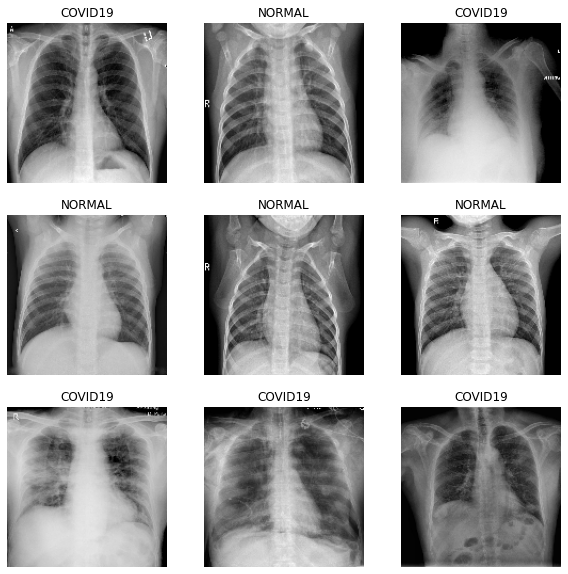

In [71]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


# Data Preprocessing and Augmentation

In [72]:
gen_train = ImageDataGenerator(rescale=1./255,
                               featurewise_center=True,
                               featurewise_std_normalization=True,
                               rotation_range=10,
                               validation_split=0.2,
                               zoom_range=0.2)

gen_test = ImageDataGenerator(rescale=1./255)


train_generator = gen_train.flow_from_directory(train_dir, 
                                                target_size=(150, 150),
                                                subset='training',
                                                batch_size=32,
                                                class_mode='binary')

val_generator = gen_train.flow_from_directory(train_dir,
                                             target_size=(150, 150),
                                             subset='validation',
                                             batch_size=32,
                                             class_mode='binary')

test_generator = gen_test.flow_from_directory(test_dir,
                                             target_size=(150, 150),
                                             batch_size=32,
                                             class_mode='binary')


Found 1449 images belonging to 2 classes.
Found 362 images belonging to 2 classes.
Found 484 images belonging to 2 classes.


In [73]:
# get the class indices
train_generator.class_indices


{'COVID19': 0, 'NORMAL': 1}

In [74]:
# get the image shape
train_generator.image_shape


(150, 150, 3)

# Build CNN

In [75]:
# instantite the Sequential class to group a linear stack of layers
model = Sequential()

# add the convolutional layer
# filters, size of filters, padding, actiation_function, input shape
model.add(Conv2D(32, (5, 5), 
                 padding='SAME', 
                 activation='relu',
                 input_shape=(150, 150, 3),
                 ))

#  pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

#  dropout layer
model.add(Dropout(0.5))

# add another convolutional layer
model.add(Conv2D(64, (5, 5,),
                 padding='SAME',
                 activation='relu',
                 ))

# pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# dropout layer
model.add(Dropout(0.5))

# flatten layer
model.add(Flatten())

# add a dense layer
model.add(Dense(256, activation='relu'))

# place a dropout layer
model.add(Dropout(0.5))

# 
model.add(Dense(1, activation='sigmoid'))

# show model architecture
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 64)        51264     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 37, 37, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 87616)            

# Compile and train model

In [76]:
# compile model
model.compile(Adam(learning_rate=0.001),
                   loss='binary_crossentropy',
                    metrics=['accuracy'])


In [77]:
# train the model
%%time

history = model.fit(train_generator,
                    epochs=12,
                    validation_data= val_generator)


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/12
46/46 [==============================] - 47s 1s/step - loss: 1.4758 - accuracy: 0.6846 - val_loss: 0.3586 - val_accuracy: 0.8287
Epoch 2/12
46/46 [==============================] - 46s 1s/step - loss: 0.2349 - accuracy: 0.9103 - val_loss: 0.2127 - val_accuracy: 0.9558
Epoch 3/12
46/46 [==============================] - 46s 997ms/step - loss: 0.1955 - accuracy: 0.9262 - val_loss: 0.2695 - val_accuracy: 0.9171
Epoch 4/12
46/46 [==============================] - 46s 1s/step - loss: 0.1434 - accuracy: 0.9538 - val_loss: 0.1246 - val_accuracy: 0.9641
Epoch 5/12
46/46 [==============================] - 46s 996ms/step - loss: 0.1325 - accuracy: 0.9503 - val_loss: 0.1734 - val_accuracy: 0.9448
Epoch 6/12
46/46 [==============================] - 46s 994ms/step - loss: 0.1294 - accuracy: 0.9586 - val_loss: 0.1124 - val_accuracy: 0.9475
Epoch 7/12
46/46 [==============================] - 46s 994ms/step - loss: 0.1410 - accuracy: 0.9524 - val_loss: 0.0979 - val_accuracy: 0.9586
Epoch 8/

# Performance and Evaluation

In [78]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 0, 'epoch')

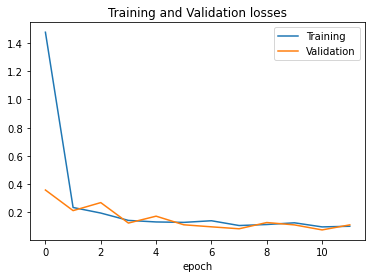

In [79]:
# plot losses
plt.plot(history.history['loss'])
plt.plot((history.history['val_loss']))

plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')


Text(0.5, 0, 'epoch')

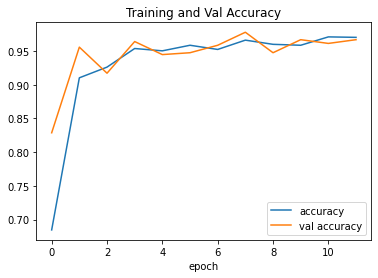

In [80]:
# plot accuracies
plt.plot(history.history['accuracy'])
plt.plot((history.history['val_accuracy']))

plt.legend(['accuracy', 'val accuracy'])
plt.title('Training and Val Accuracy')
plt.xlabel('epoch')


In [81]:
# get test and accuracy loss

test_loss, test_acc = model.evaluate(test_generator)
print('test loss: {} test acc: {}'.format(test_loss, test_acc))

16/16 [==============================] - 10s 612ms/step - loss: 0.1109 - accuracy: 0.9649
test loss: 0.11093798279762268 test acc: 0.9648760557174683


# Predict on New Data

In [82]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for filename in uploaded.keys():
    img_path = '/content/' + filename
    img = image.load_img(img_path, target_size=(150, 150))
    images = image.img_to_array(img)
    images = np.expand_dims(images, axis=0)
    preds = model.predict(images)
    print(filename)

    if preds == 0:
        print('Covid detected')
    else:
        print('Normal')


Saving covid1.jpg to covid1 (3).jpg
Saving covid2.jpeg to covid2 (2).jpeg
Saving normal1.jpg to normal1 (2).jpg
Saving normal2.jpg to normal2 (2).jpg
covid1.jpg
Covid detected
covid2.jpeg
Covid detected
normal1.jpg
Normal
normal2.jpg
Normal
